# Bagmati catchment
# 3. GRU
## Keras tuner using random search class

# Hyperparameter tuning using model_builder function from tensorflow   (Standard normalization)
(After midterm)
#(https://www.tensorflow.org/tutorials/keras/keras_tuner)

In [1]:
import numpy as np
import pandas as pd

### define file path
path = 'Non_scaled_6_input_Bagmati_yr.csv'  ####### This excel data is not scaled/normalized
## Read CSV file and convert it to dataframe
df = pd.read_csv( path, sep = ',', header = 'infer')


In [2]:
df

,Rt,Rt_1,Rt_2,Rt_3,Rt_4,Rt_5,Qt
0,0.878,25.060,3.613,8.190,1.608,28.160,299.0
1,0.000,0.878,25.060,3.613,8.190,1.608,182.0
2,25.527,0.000,0.878,25.060,3.613,8.190,151.0
3,36.896,25.527,0.000,0.878,25.060,3.613,561.0
4,6.184,36.896,25.527,0.000,0.878,25.060,384.0
...,...,...,...,...,...,...,...
2909,7.115,0.422,7.130,13.781,4.314,18.381,132.0
2910,3.118,7.115,0.422,7.130,13.781,4.314,107.0
2911,61.877,3.118,7.115,0.422,7.130,13.781,538.0
2912,112.900,61.877,3.118,7.115,0.422,7.130,921.0


In [3]:
df.describe()

,Rt,Rt_1,Rt_2,Rt_3,Rt_4,Rt_5,Qt
count,2914.000000,2914.000000,2914.000000,2914.000000,2914.000000,2914.000000,2914.000000
mean,5.433136,5.434821,5.397316,5.378893,5.378374,5.385596,149.648264
std,14.030448,14.032511,13.890520,13.851130,13.851243,13.857633,271.208820
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.100000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.800000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.700000
75%,4.916000,4.916000,4.864500,4.864500,4.864500,4.864500,195.975000
max,364.590000,364.590000,364.590000,364.590000,364.590000,364.590000,5030.000000


# 1. Data splitting

##  Train, Validation and Test data 
###  70% train (2040 data points)
###  15% train (436 data points)
###  15% train (436 data points)

In [4]:
df_train = df.iloc[:2040]

df_val = df.iloc[2040:2476] 

df_test = df.iloc[2476:2912] 

# 2. Normalization

In [5]:
import pandas as pd
import numpy as np

### General function for all the normalization methods

def normalize_df(data, norm_method):     

    ## Normalize data using specified method
 
    if norm_method == 'minmax':
        # Min-Max normalization
        data = (data - data.min()) / (data.max() - data.min())
    elif norm_method == 'zscore':
        # Z-score normalization
        mean = data.mean()
        std = data.std()
        data = (data - mean) / std
    elif norm_method == 'max':
        # Max normalization
        data = 1 - ((data.max() - data)/data.max())
    else:
        raise ValueError("Invalid normalization method. Choose from: 'minmax', 'zscore', 'max'")
    return data



### Standard normalization  (Date sets for training, validation and testing are nromalized separately)

In [6]:
## Z_score(standard)
df_train_norm = normalize_df(df_train, 'zscore')
df_val_norm = normalize_df(df_val, 'zscore')
df_test_norm = normalize_df(df_test, 'zscore')

In [7]:
###example
df_train_norm.describe()

,Rt,Rt_1,Rt_2,Rt_3,Rt_4,Rt_5,Qt
count,2.040000e+03,2.040000e+03,2.040000e+03,2.040000e+03,2.040000e+03,2.040000e+03,2.040000e+03
mean,-2.590520e-17,5.329615e-16,-1.793772e-16,5.066753e-17,2.870797e-16,-2.443579e-17,2.166023e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.668091e-01,-3.674980e-01,-3.676080e-01,-3.678887e-01,-3.679488e-01,-3.686857e-01,-5.277226e-01
25%,-3.668091e-01,-3.674980e-01,-3.676080e-01,-3.678887e-01,-3.679488e-01,-3.686857e-01,-4.900124e-01
50%,-3.668091e-01,-3.674980e-01,-3.676080e-01,-3.678887e-01,-3.679488e-01,-3.686857e-01,-3.891311e-01
75%,-5.646773e-02,-5.666901e-02,-5.677197e-02,-5.549026e-02,-5.554508e-02,-5.307515e-02,1.998830e-01
max,2.456513e+01,2.455419e+01,2.455464e+01,2.455494e+01,2.455530e+01,2.454060e+01,1.705836e+01


In [8]:
### convert the dataframes to numpy arrays

df_train_f = df_train_norm.to_numpy()

df_val_f = df_val_norm.to_numpy()

df_test_f = df_test_norm.to_numpy()

In [9]:
### Define input and output sequences (list of sub sequences)

def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
    # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
    # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
    # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1] 
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps_in, n_steps_out = 1, 1    ####  input sequences and  output sequences



### Split into input and target variables

In [10]:
#### Training data


X_train, y_train = split_sequences(df_train_f, n_steps_in, n_steps_out)
print(X_train.shape, y_train.shape)

# reshape from [samples, timesteps] into [samples, timesteps, features]

n_features = 6

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
print(X_train.shape)


(2040, 1, 6) (2040, 1)
(2040, 1, 6)


In [11]:
#### validation data

X_val, y_val = split_sequences(df_val_f , n_steps_in, n_steps_out)


X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))

### reshape

X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))

print(X_val.shape, y_val.shape)


(436, 1, 6) (436, 1)


In [12]:
#### Test data

X_test, y_test = split_sequences(df_test_f , n_steps_in, n_steps_out)

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

print(X_test.shape, y_test.shape)


(436, 1, 6) (436, 1)


In [13]:
#### model fitting
import keras
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import save_model

from tensorflow.keras import initializers

from tensorflow.keras import layers


## Hyperparameter tuning using KerasTuner

In [14]:

import keras_tuner as kt


from keras_tuner.engine.hyperparameters import HyperParameters
from keras_tuner.engine.hyperparameters import Choice,Float

### a. Define model (Using model_buider function)
### (https://www.tensorflow.org/tutorials/keras/keras_tuner)
## GRU

In [15]:
def model_builder(hp):
    model = keras.Sequential()
    ###1. tune the units
    hp_units = hp.Int('units', min_value = 1, max_value = 10, step = 1)
    ###2. tune weight initialization
    hp_initializer=hp.Choice('weight_init', ['he_uniform', 'glorot_uniform', 'random_normal' , 'lecun_normal'])
    ###3. tune activation function
    hp_activation = hp.Choice("activation", ["relu", "tanh", "sigmoid"]) 
    
    ### Fix the seeds for reproducibility purposes     
    if hp_initializer == 'he_uniform':
        init = tf.keras.initializers.he_uniform(seed=1)
    elif hp_initializer == 'glorot_uniform':
        init = tf.keras.initializers.glorot_uniform(seed=1)
    elif hp_initializer == 'random_normal':
        init = tf.keras.initializers.RandomNormal(seed=1)
    else:
        init = tf.keras.initializers.lecun_normal(seed=1)
   

     ##3. Tune number of layers
    ## 4. Tune dropout rates
    for i in range(hp.Int("num_layers", 1, 3)):
        
        model.add(keras.layers.GRU(units=hp_units,
                                activation = hp_activation,
                                return_sequences=True,
                                kernel_initializer = init))
        model.add(Dropout(hp.Float('dropout_rate', 0, 0.3, step=0.1)))
        
#     model.add(keras.layers.LSTM(units=hp.Int('units', min_value=1, max_value=10, step=1),
#                                 kernel_initializer = hp.Choice('weight_init', ['he_uniform', 'glorot_uniform', 'random_normal' , 'lecun_normal'])))
#     model.add(Dropout(hp.Float('dropout_rate', 0, 0.3, step=0.1)))
    
    model.add(keras.layers.Dense(1, kernel_initializer = init))
    ##5. Tune optimizer
    hp_optimizer = hp.Choice("optimizer", ['Adam', 'SGD', 'RMSprop'])

    model.compile (optimizer = hp_optimizer, 
                   loss='mean_squared_error',
                   metrics=[tf.keras.metrics.MeanSquaredError()])
    
    return model

### b.  Instantiate the tuner and perform hypertuning

In [20]:
from keras_tuner.tuners import RandomSearch

tuner = RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=50,
    executions_per_trial=1,
    seed = 1,
    directory='Exhaustive_Opt_norm_final_yr',
    project_name='Randomsearch_1_GRU'
)

In [17]:
from keras.callbacks import TensorBoard

import datetime, os

log_dir = "Exhaustive_Opt_norm_final_yr/Randomsearch_1_GRU"
# tf.keras.callbacks.TensorBoard("Exhaustive_Opt_norm_final_yr/Randomsearch_1_GRU")

In [18]:
#tb = TensorBoard(log_dir=log_dir)
tb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [19]:
### Create a callback to stop training early after reaching a certain value for the validation loss.

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

### C. Run hyperparameter search 

# 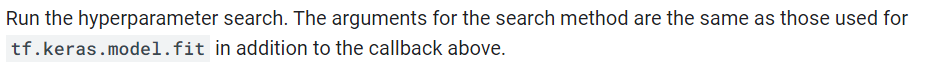

In [175]:
tuner.search(X_train, y_train, 
             epochs=200, 
             validation_data=(X_val, y_val), 
             callbacks=[stop_early,tf.keras.callbacks.TensorBoard("Exhaustive_Opt_norm_final_yr/Randomsearch_1_GRU")])

Trial 50 Complete [00h 00m 29s]
val_loss: 0.2778462767601013

Best val_loss So Far: 0.2673885226249695
Total elapsed time: 00h 26m 39s
INFO:tensorflow:Oracle triggered exit


In [176]:
tuner.results_summary()

Results summary
Results in Exhaustive_Opt_norm\Randomsearch_3_GRU
Showing 10 best trials
Trial summary
Hyperparameters:
units: 7
weight_init: lecun_normal
activation: relu
num_layers: 2
dropout_rate: 0.1
optimizer: RMSprop
Score: 0.2673885226249695
Trial summary
Hyperparameters:
units: 9
weight_init: he_uniform
activation: sigmoid
num_layers: 1
dropout_rate: 0.1
optimizer: RMSprop
Score: 0.2778462767601013
Trial summary
Hyperparameters:
units: 6
weight_init: random_normal
activation: relu
num_layers: 2
dropout_rate: 0.1
optimizer: RMSprop
Score: 0.27959874272346497
Trial summary
Hyperparameters:
units: 7
weight_init: glorot_uniform
activation: tanh
num_layers: 1
dropout_rate: 0.2
optimizer: Adam
Score: 0.28011760115623474
Trial summary
Hyperparameters:
units: 9
weight_init: random_normal
activation: tanh
num_layers: 2
dropout_rate: 0.0
optimizer: RMSprop
Score: 0.28540927171707153
Trial summary
Hyperparameters:
units: 10
weight_init: random_normal
activation: sigmoid
num_layers: 2
drop

In [21]:
%load_ext tensorboard
#%tensorboard --logdir "Exhaustive_Opt_norm_final_yr/Randomsearch_1_GRU"  

### change the port number if the above line doesn't work

%tensorboard --logdir "Exhaustive_Opt_norm_final_yr/Randomsearch_1_GRU" --port 6008  

## d.  get the optimal hyperparameters

In [1]:

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


# print(f"""
# The hyperparameter search is complete. The optimal number of units in the first densely-connected
# layer is {best_hps.get('units')} and the optimal optimizer is {best_hps.get('optimizer')}.
# """)

print(f"""
The hyperparameter search is complete. 

The optimal number of units in the first densely-connected layer is {best_hps.get('units')}, 
The optimal activation function is {best_hps.get('activation')},
The optimal weight initialization is {best_hps.get('weight_init')}
The optimal optimizer is {best_hps.get('optimizer')}.
The optimal number of layers is {best_hps.get('num_layers')},
The optimal dropout rate is {best_hps.get('dropout_rate')},

""")


NameError: name 'tuner' is not defined

## e. Train the model using the best model

In [180]:
import random
random.seed(1)

tf.random.set_seed(1) 
model = tuner.hypermodel.build(best_hps)


In [181]:
### model training 
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

GRU_ex_op1 = model.fit(X_train, y_train, epochs=300, validation_data = (X_val, y_val), shuffle = 0  )  ##callbacks=[early_stopping]


Epoch 1/300
64/64 [==============================] - 6s 20ms/step - loss: 0.9828 - mean_squared_error: 0.9828 - val_loss: 0.9401 - val_mean_squared_error: 0.9401
Epoch 2/300
64/64 [==============================] - 1s 9ms/step - loss: 0.9334 - mean_squared_error: 0.9334 - val_loss: 0.8769 - val_mean_squared_error: 0.8769
Epoch 3/300
64/64 [==============================] - 0s 5ms/step - loss: 0.8868 - mean_squared_error: 0.8868 - val_loss: 0.8200 - val_mean_squared_error: 0.8200
Epoch 4/300
64/64 [==============================] - 0s 5ms/step - loss: 0.8458 - mean_squared_error: 0.8458 - val_loss: 0.7670 - val_mean_squared_error: 0.7670
Epoch 5/300
64/64 [==============================] - 0s 5ms/step - loss: 0.8120 - mean_squared_error: 0.8120 - val_loss: 0.7071 - val_mean_squared_error: 0.7071
Epoch 6/300
64/64 [==============================] - 0s 5ms/step - loss: 0.7629 - mean_squared_error: 0.7629 - val_loss: 0.6545 - val_mean_squared_error: 0.6545
Epoch 7/300
64/64 [==============

64/64 [==============================] - 0s 4ms/step - loss: 0.2136 - mean_squared_error: 0.2136 - val_loss: 0.2660 - val_mean_squared_error: 0.2660
Epoch 102/300
64/64 [==============================] - 0s 4ms/step - loss: 0.1995 - mean_squared_error: 0.1995 - val_loss: 0.2686 - val_mean_squared_error: 0.2686
Epoch 103/300
64/64 [==============================] - 0s 4ms/step - loss: 0.2783 - mean_squared_error: 0.2783 - val_loss: 0.2670 - val_mean_squared_error: 0.2670
Epoch 104/300
64/64 [==============================] - 0s 4ms/step - loss: 0.2676 - mean_squared_error: 0.2676 - val_loss: 0.2652 - val_mean_squared_error: 0.2652
Epoch 105/300
64/64 [==============================] - 0s 4ms/step - loss: 0.2067 - mean_squared_error: 0.2067 - val_loss: 0.2660 - val_mean_squared_error: 0.2660
Epoch 106/300
64/64 [==============================] - 0s 6ms/step - loss: 0.2194 - mean_squared_error: 0.2194 - val_loss: 0.2663 - val_mean_squared_error: 0.2663
Epoch 107/300
64/64 [===============

64/64 [==============================] - 0s 5ms/step - loss: 0.1743 - mean_squared_error: 0.1743 - val_loss: 0.2775 - val_mean_squared_error: 0.2775
Epoch 202/300
64/64 [==============================] - 0s 5ms/step - loss: 0.2055 - mean_squared_error: 0.2055 - val_loss: 0.2775 - val_mean_squared_error: 0.2775
Epoch 203/300
64/64 [==============================] - 0s 5ms/step - loss: 0.2021 - mean_squared_error: 0.2021 - val_loss: 0.2766 - val_mean_squared_error: 0.2766
Epoch 204/300
64/64 [==============================] - 0s 5ms/step - loss: 0.1758 - mean_squared_error: 0.1758 - val_loss: 0.2774 - val_mean_squared_error: 0.2774
Epoch 205/300
64/64 [==============================] - 0s 5ms/step - loss: 0.2008 - mean_squared_error: 0.2008 - val_loss: 0.2792 - val_mean_squared_error: 0.2792
Epoch 206/300
64/64 [==============================] - 0s 5ms/step - loss: 0.2077 - mean_squared_error: 0.2077 - val_loss: 0.2799 - val_mean_squared_error: 0.2799
Epoch 207/300
64/64 [===============

In [182]:
model.summary()   #### this shows us that the number of layers are 3 in this MLP model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 1, 7)              315       
                                                                 
 dropout_1 (Dropout)         (None, 1, 7)              0         
                                                                 
 gru_2 (GRU)                 (None, 1, 7)              336       
                                                                 
 dropout_2 (Dropout)         (None, 1, 7)              0         
                                                                 
 dense_1 (Dense)             (None, 1, 1)              8         
                                                                 
Total params: 659
Trainable params: 659
Non-trainable params: 0
_________________________________________________________________


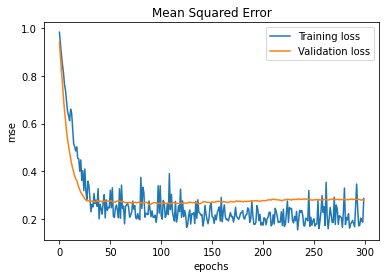

In [183]:
import matplotlib.pyplot as plt
plt.plot(GRU_ex_op1.history['mean_squared_error'], label = 'Training loss')
plt.plot(GRU_ex_op1.history['val_mean_squared_error'], label = 'Validation loss')
plt.title('Mean Squared Error')
plt.xlabel('epochs')
plt.ylabel('mse')
plt.legend()

In [184]:
#### find the best epoch by looking in to the validation loss

val_loss_per_epoch = GRU_ex_op1.history['val_loss']   

#### 'val_loss' should align with the objective function used when applying 'tuner.search' (both should be loss or both accuracy)

best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1

print('Best epoch: %d' % (best_epoch,))

Best epoch: 89


In [185]:
### Re-instantiate the hypermodel and train it with the optimal number of epochs from above.

hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model

hypermodel.fit(X_train, y_train, epochs= best_epoch, verbose = 1, validation_data=(X_val, y_val), shuffle = False) 

# hypermodel.fit(X_train, y_train, epochs= 250, verbose = 1, validation_data=(X_val, y_val), shuffle = False) 


Epoch 1/89
64/64 [==============================] - 5s 16ms/step - loss: 0.9828 - mean_squared_error: 0.9828 - val_loss: 0.9401 - val_mean_squared_error: 0.9401
Epoch 2/89
64/64 [==============================] - 0s 4ms/step - loss: 0.9334 - mean_squared_error: 0.9334 - val_loss: 0.8769 - val_mean_squared_error: 0.8769
Epoch 3/89
64/64 [==============================] - 0s 4ms/step - loss: 0.8868 - mean_squared_error: 0.8868 - val_loss: 0.8200 - val_mean_squared_error: 0.8200
Epoch 4/89
64/64 [==============================] - 0s 4ms/step - loss: 0.8458 - mean_squared_error: 0.8458 - val_loss: 0.7670 - val_mean_squared_error: 0.7670
Epoch 5/89
64/64 [==============================] - 0s 4ms/step - loss: 0.8120 - mean_squared_error: 0.8120 - val_loss: 0.7071 - val_mean_squared_error: 0.7071
Epoch 6/89
64/64 [==============================] - 0s 4ms/step - loss: 0.7629 - mean_squared_error: 0.7629 - val_loss: 0.6545 - val_mean_squared_error: 0.6545
Epoch 7/89
64/64 [=====================

Epoch 52/89
64/64 [==============================] - 0s 4ms/step - loss: 0.2470 - mean_squared_error: 0.2470 - val_loss: 0.2769 - val_mean_squared_error: 0.2769
Epoch 53/89
64/64 [==============================] - 0s 4ms/step - loss: 0.3311 - mean_squared_error: 0.3311 - val_loss: 0.2718 - val_mean_squared_error: 0.2718
Epoch 54/89
64/64 [==============================] - 0s 4ms/step - loss: 0.2111 - mean_squared_error: 0.2111 - val_loss: 0.2714 - val_mean_squared_error: 0.2714
Epoch 55/89
64/64 [==============================] - 0s 5ms/step - loss: 0.2073 - mean_squared_error: 0.2073 - val_loss: 0.2724 - val_mean_squared_error: 0.2724
Epoch 56/89
64/64 [==============================] - 0s 4ms/step - loss: 0.2451 - mean_squared_error: 0.2451 - val_loss: 0.2704 - val_mean_squared_error: 0.2704
Epoch 57/89
64/64 [==============================] - 0s 4ms/step - loss: 0.2593 - mean_squared_error: 0.2593 - val_loss: 0.2744 - val_mean_squared_error: 0.2744
Epoch 58/89
64/64 [===============

## f. Test best model

In [186]:

eval_result = model.evaluate(X_test, y_test)

print("[test loss, test accuracy]:", eval_result)

14/14 [==============================] - 0s 3ms/step - loss: 0.2567 - mean_squared_error: 0.2567
[test loss, test accuracy]: [0.2566993832588196, 0.2566993832588196]


In [187]:
Y_pred = hypermodel.predict(X_test)   ### results from the hypermodel are giving fluctuating results
# Y_pred = model.predict(X_test)   #### this is giving better result(more stable)

14/14 [==============================] - 0s 2ms/step


In [188]:
Y_pred

array([[[-4.8981148e-01]],

       [[-4.9094450e-01]],

       [[-4.9071407e-01]],

       [[-4.8872483e-01]],

       [[-4.9195236e-01]],

       [[-4.9195236e-01]],

       [[-4.9195236e-01]],

       [[-4.9195236e-01]],

       [[-4.9195236e-01]],

       [[-4.9195236e-01]],

       [[-4.9195236e-01]],

       [[-4.9195236e-01]],

       [[-4.9195236e-01]],

       [[-4.9195236e-01]],

       [[-4.7116083e-01]],

       [[-2.4523973e-01]],

       [[-1.2790188e-01]],

       [[-1.4663801e-01]],

       [[-1.6553003e-01]],

       [[-1.5565813e-01]],

       [[ 1.5551384e-01]],

       [[-1.0594719e-01]],

       [[-1.3681361e-01]],

       [[-2.3649949e-01]],

       [[-2.1907818e-01]],

       [[-1.9263253e-01]],

       [[ 1.0060076e-01]],

       [[ 4.1058809e-01]],

       [[ 7.1885079e-01]],

       [[ 1.6390799e+00]],

       [[ 8.6855042e-01]],

       [[ 7.4650013e-01]],

       [[ 9.8197192e-01]],

       [[ 7.7000910e-01]],

       [[ 4.2129669e-01]],

       [[ 7.7883971e

In [189]:
print(Y_pred.shape)

Y_pred = Y_pred.reshape(436,1)

(436, 1, 1)


In [190]:
# Y_pred[:,-1]
Y_pred

array([[-4.8981148e-01],
       [-4.9094450e-01],
       [-4.9071407e-01],
       [-4.8872483e-01],
       [-4.9195236e-01],
       [-4.9195236e-01],
       [-4.9195236e-01],
       [-4.9195236e-01],
       [-4.9195236e-01],
       [-4.9195236e-01],
       [-4.9195236e-01],
       [-4.9195236e-01],
       [-4.9195236e-01],
       [-4.9195236e-01],
       [-4.7116083e-01],
       [-2.4523973e-01],
       [-1.2790188e-01],
       [-1.4663801e-01],
       [-1.6553003e-01],
       [-1.5565813e-01],
       [ 1.5551384e-01],
       [-1.0594719e-01],
       [-1.3681361e-01],
       [-2.3649949e-01],
       [-2.1907818e-01],
       [-1.9263253e-01],
       [ 1.0060076e-01],
       [ 4.1058809e-01],
       [ 7.1885079e-01],
       [ 1.6390799e+00],
       [ 8.6855042e-01],
       [ 7.4650013e-01],
       [ 9.8197192e-01],
       [ 7.7000910e-01],
       [ 4.2129669e-01],
       [ 7.7883971e-01],
       [ 1.1665096e+00],
       [ 4.0992364e-01],
       [-1.2487324e-01],
       [-7.5676695e-02],


In [191]:
y_test

array([[-5.98808761e-01],
       [-6.00386034e-01],
       [-6.00386034e-01],
       [-5.98808761e-01],
       [-5.99860276e-01],
       [-5.97231489e-01],
       [-5.98808761e-01],
       [-6.00386034e-01],
       [-6.00386034e-01],
       [-6.01437548e-01],
       [-6.01963306e-01],
       [-6.03540578e-01],
       [-6.04592093e-01],
       [-6.05117850e-01],
       [-6.04592093e-01],
       [-5.86716341e-01],
       [-5.86716341e-01],
       [-5.60428470e-01],
       [-5.71995133e-01],
       [-5.78829979e-01],
       [-5.79355737e-01],
       [-5.74623920e-01],
       [-3.87454278e-01],
       [-4.44761837e-01],
       [-5.17316361e-01],
       [-4.87348188e-01],
       [-3.65372467e-01],
       [ 1.58807682e-01],
       [ 1.19901633e-01],
       [ 7.29254483e-01],
       [ 1.45663746e-01],
       [ 1.55653137e-01],
       [ 1.25159207e-01],
       [-3.43290655e-01],
       [-3.74836100e-01],
       [ 6.06753004e-01],
       [ 9.67683062e-02],
       [-4.00072456e-01],
       [-4.8

In [192]:
y_test.shape

(436, 1)

In [193]:
print(y_test[:,:-1].shape)   
print(y_test[:,1:2].shape)

(436, 0)
(436, 0)


In [194]:
y_test[:,-1:]    ##### all rows and all columns including -1(which is the last column)

array([[-5.98808761e-01],
       [-6.00386034e-01],
       [-6.00386034e-01],
       [-5.98808761e-01],
       [-5.99860276e-01],
       [-5.97231489e-01],
       [-5.98808761e-01],
       [-6.00386034e-01],
       [-6.00386034e-01],
       [-6.01437548e-01],
       [-6.01963306e-01],
       [-6.03540578e-01],
       [-6.04592093e-01],
       [-6.05117850e-01],
       [-6.04592093e-01],
       [-5.86716341e-01],
       [-5.86716341e-01],
       [-5.60428470e-01],
       [-5.71995133e-01],
       [-5.78829979e-01],
       [-5.79355737e-01],
       [-5.74623920e-01],
       [-3.87454278e-01],
       [-4.44761837e-01],
       [-5.17316361e-01],
       [-4.87348188e-01],
       [-3.65372467e-01],
       [ 1.58807682e-01],
       [ 1.19901633e-01],
       [ 7.29254483e-01],
       [ 1.45663746e-01],
       [ 1.55653137e-01],
       [ 1.25159207e-01],
       [-3.43290655e-01],
       [-3.74836100e-01],
       [ 6.06753004e-01],
       [ 9.67683062e-02],
       [-4.00072456e-01],
       [-4.8

## Evaluation metics

In [195]:
###nse

import hydroeval as he
nse = he.evaluator(he.nse, Y_pred, y_test )
print(nse)

[0.7458041]


In [196]:
##rmse
rmse = he.evaluator(he.rmse, Y_pred, y_test )
print(rmse)

[0.50359992]


In [197]:
###logrmse
from sklearn.metrics import mean_squared_error
#### log of predicted values
y_pred_lg = np.log1p(Y_pred)

#### log of test values
y_test_lg = np.log1p(y_test)


In [198]:
##calculate mse
mse = mean_squared_error(y_pred_lg, y_test_lg)
rmse_lg = np.sqrt(mse)   
print(rmse_lg)

0.3859491575074414









## g. plot

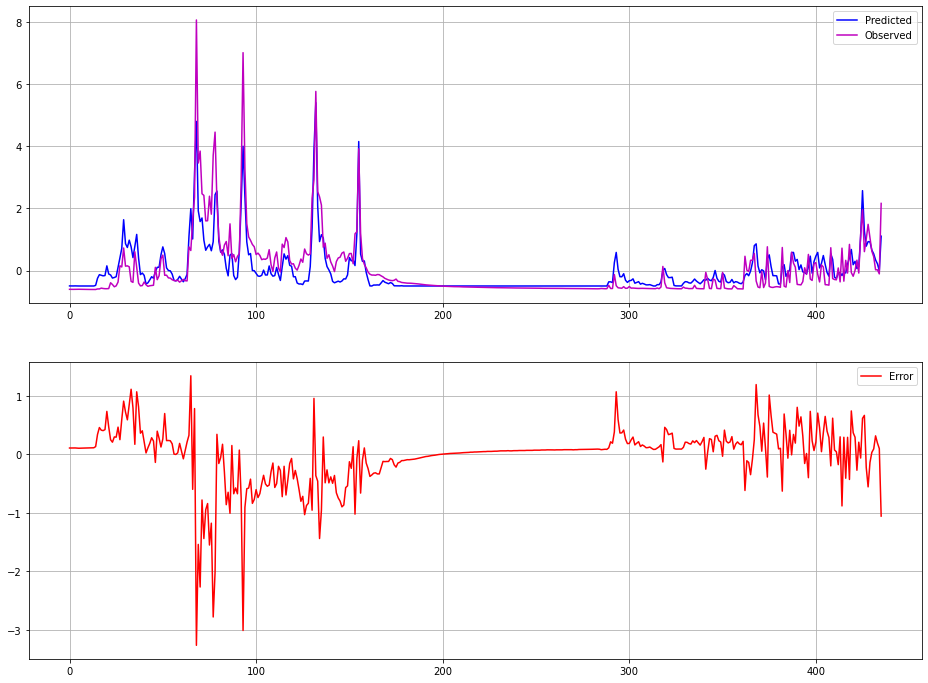

In [199]:
import matplotlib.pyplot as plt
# plt.plot(Q_pred)
# plt.plot(y_test)

plt.figure(figsize = (16, 12))

plt.subplot(2, 1, 1)

plt.plot(Y_pred,'b', label = "Predicted")

plt.plot(y_test[:,-1], 'm',  label = "Observed")  

plt.legend()
plt.grid()

plt.subplot(2,1,2)

plt.plot(Y_pred - y_test,'r', label = "Error")

plt.legend()

plt.grid()

##  save_model

## h. Denormalize the data

In [200]:
#### Original data
df_train_norm

# df_val_f

# df_test_f

,Rt,Rt_1,Rt_2,Rt_3,Rt_4,Rt_5,Qt
0,-0.306768,1.345488,-0.120634,0.191968,-0.258026,1.555244,0.500865
1,-0.366809,-0.307482,1.345417,-0.120909,0.191917,-0.258825,0.091390
2,1.378816,-0.367498,-0.307591,1.345176,-0.120965,0.190866,-0.017104
3,2.156268,1.377410,-0.367608,-0.307870,1.345145,-0.121841,1.417809
4,0.056074,2.154542,1.377339,-0.367889,-0.307929,1.343448,0.798347
...,...,...,...,...,...,...,...
2035,-0.366809,-0.367498,-0.367608,-0.367889,-0.367949,-0.368686,-0.494825
2036,-0.366809,-0.367498,-0.367608,-0.367889,-0.367949,-0.368686,-0.494825
2037,-0.362091,-0.367498,-0.367608,-0.367889,-0.367949,-0.368686,-0.494825
2038,-0.327215,-0.362781,-0.367608,-0.367889,-0.367949,-0.368686,-0.496575


In [201]:
### normalized data after model training
Y_pred    #### model out put
# y_obser = y_test[:,-1:]      ## observed discharge

array([[-4.8981148e-01],
       [-4.9094450e-01],
       [-4.9071407e-01],
       [-4.8872483e-01],
       [-4.9195236e-01],
       [-4.9195236e-01],
       [-4.9195236e-01],
       [-4.9195236e-01],
       [-4.9195236e-01],
       [-4.9195236e-01],
       [-4.9195236e-01],
       [-4.9195236e-01],
       [-4.9195236e-01],
       [-4.9195236e-01],
       [-4.7116083e-01],
       [-2.4523973e-01],
       [-1.2790188e-01],
       [-1.4663801e-01],
       [-1.6553003e-01],
       [-1.5565813e-01],
       [ 1.5551384e-01],
       [-1.0594719e-01],
       [-1.3681361e-01],
       [-2.3649949e-01],
       [-2.1907818e-01],
       [-1.9263253e-01],
       [ 1.0060076e-01],
       [ 4.1058809e-01],
       [ 7.1885079e-01],
       [ 1.6390799e+00],
       [ 8.6855042e-01],
       [ 7.4650013e-01],
       [ 9.8197192e-01],
       [ 7.7000910e-01],
       [ 4.2129669e-01],
       [ 7.7883971e-01],
       [ 1.1665096e+00],
       [ 4.0992364e-01],
       [-1.2487324e-01],
       [-7.5676695e-02],


In [202]:
def denormalize(data, original_data, type='min_max'):   ### default is min-max in this case(there is no reason behind this)

    if type == 'min_max':
        min = np.min(original_data)
        max = np.max(original_data)
        data = data * (max - min) + min
    elif type == 'z_score':
        mean = np.mean(original_data)
        std = np.std(original_data)
        data = data * std + mean
    elif type == 'max':                
        max = np.max(original_data)
        data = data * max
    else:
        raise ValueError("Invalid normalization type. Choose either 'max', 'min_max', or 'z_score'.")
    return data

In [203]:
Y_observ_unnorm = df_test['Qt']

In [204]:
Y_observ_unnorm = Y_observ_unnorm.to_numpy()

###  denormalized predicted discharge

In [205]:
### Standard denormalization (becasue we used standard(z-score) in this experiment)

Y_pred_denorm = denormalize(Y_pred, Y_observ_unnorm, type='z_score')

In [206]:
print(Y_pred_denorm)
print(Y_pred_denorm.shape)

[[  33.438385]
 [  33.22313 ]
 [  33.266907]
 [  33.64483 ]
 [  33.031647]
 [  33.031647]
 [  33.031647]
 [  33.031647]
 [  33.031647]
 [  33.031647]
 [  33.031647]
 [  33.031647]
 [  33.031647]
 [  33.031647]
 [  36.981697]
 [  79.902985]
 [ 102.19525 ]
 [  98.6357  ]
 [  95.046524]
 [  96.92202 ]
 [ 156.03957 ]
 [ 106.36628 ]
 [ 100.50217 ]
 [  81.56349 ]
 [  84.87325 ]
 [  89.89749 ]
 [ 145.607   ]
 [ 204.49948 ]
 [ 263.0643  ]
 [ 437.8927  ]
 [ 291.5048  ]
 [ 268.31723 ]
 [ 313.053   ]
 [ 272.78354 ]
 [ 206.53394 ]
 [ 274.4612  ]
 [ 348.11212 ]
 [ 204.37325 ]
 [ 102.77064 ]
 [ 112.11717 ]
 [  97.86855 ]
 [  45.258858]
 [  52.233315]
 [  70.17691 ]
 [  89.760155]
 [  80.76665 ]
 [ 120.94463 ]
 [ 147.07286 ]
 [ 147.87466 ]
 [ 223.29208 ]
 [ 271.937   ]
 [ 231.20801 ]
 [ 143.69685 ]
 [ 127.60063 ]
 [ 125.60922 ]
 [ 105.724434]
 [  67.54777 ]
 [  64.2985  ]
 [  73.24226 ]
 [  92.27028 ]
 [  74.64339 ]
 [  58.88011 ]
 [  77.760895]
 [ 104.23324 ]
 [ 333.8959  ]
 [ 505.13016 ]
 [ 320.156

### denormalized Observed discharge

In [207]:
len(y_test)

436

In [208]:
Y_obser_denorm = denormalize(y_test, Y_observ_unnorm, type='z_score')

In [209]:
Y_obser_denorm 

array([[  12.73068793],
       [  12.43103217],
       [  12.43103217],
       [  12.73068793],
       [  12.53091742],
       [  13.0303437 ],
       [  12.73068793],
       [  12.43103217],
       [  12.43103217],
       [  12.23126166],
       [  12.1313764 ],
       [  11.83172063],
       [  11.63195012],
       [  11.53206487],
       [  11.63195012],
       [  15.0280488 ],
       [  15.0280488 ],
       [  20.02231157],
       [  17.82483595],
       [  16.52632763],
       [  16.42644238],
       [  17.32540967],
       [  52.88456055],
       [  41.99706773],
       [  28.2129025 ],
       [  33.90636205],
       [  57.07974127],
       [ 156.66534078],
       [ 149.27383189],
       [ 265.04084274],
       [ 154.16820939],
       [ 156.06602924],
       [ 150.27268444],
       [  61.27492199],
       [  55.28180668],
       [ 241.76757826],
       [ 144.87888065],
       [  50.48731442],
       [  33.90636205],
       [  35.50452613],
       [  57.57916755],
       [  40.498

# Plot the denomalized data

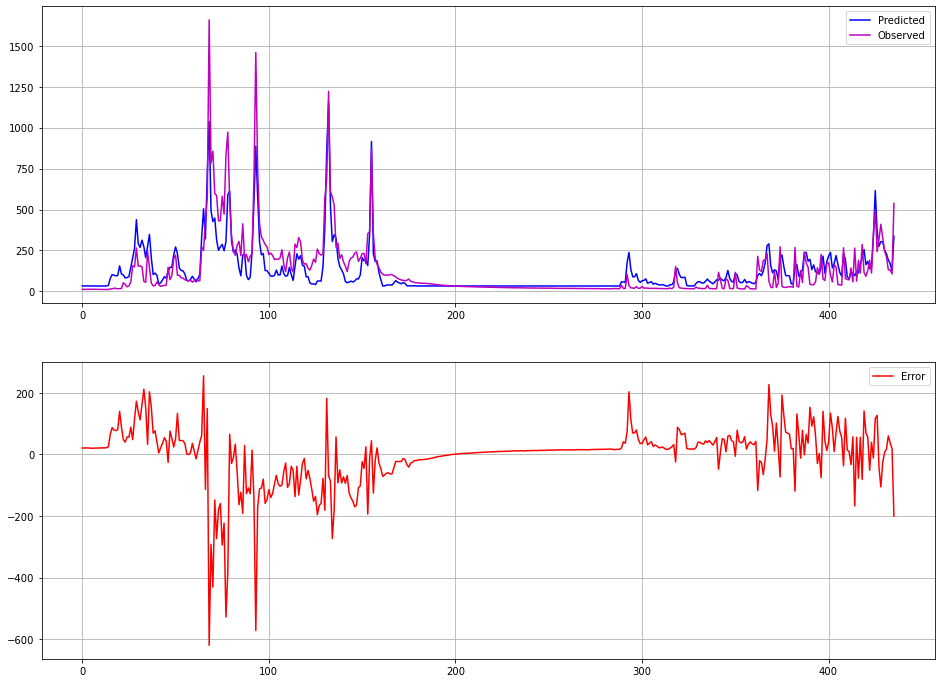

In [210]:
plt.figure(figsize = (16, 12))

plt.subplot(2, 1, 1)

plt.plot(Y_pred_denorm,'b', label = "Predicted")

plt.plot(Y_obser_denorm , 'm',  label = "Observed")  

plt.legend()
plt.grid()

plt.subplot(2,1,2)

plt.plot(Y_pred_denorm - Y_obser_denorm ,'r', label = "Error")

plt.legend()

plt.grid()

### NSE after denormalization

In [211]:
nse_d = he.evaluator(he.nse, Y_pred_denorm[:,-1] , Y_obser_denorm  )
print(nse_d)

[0.74580409]


### RMSE after denormalization (in m3/sec)

In [212]:
#### rmse in m3/sec
rmse_d = he.evaluator(he.rmse, Y_pred_denorm[:,-1], Y_obser_denorm)
print(rmse_d)    ### 

[95.67569673]
